In [1]:
from google.colab import files
import tensorflow as tf
import matplotlib as pyplot
import pandas as pd
import warnings
import logging
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
warnings.simplefilter('ignore')
tf.get_logger().setLevel(logging.ERROR)

In [5]:
features = ["Ba_avg","Q_avg","Ya_avg","Yt_avg","Ws1_avg","Ws2_avg","Ws_avg","Wa_avg","Va_avg","Ot_avg","Rs_avg","Rbt_avg","temp","pressure","humidity","wind_speed","wind_deg","rain_1h","snow_1h"]
target_feature = ["P_avg"]

In [6]:
dataset_location = '/content/drive/MyDrive/toqua/R80711.csv'
num_epoch = 1
num_GRU_layers = 1
num_GRU_neurons = 8
dropout = 0.1
n_output = 1
learning_rate = 0.001
batch_size = 128
num_sample = 100
interval = 144
n_feature = len(features)
split_rate = 0.2

In [7]:
dataset = pd.read_csv(dataset_location)
dataset.head(5)

,Date_time,Date_time_nr,Wind_turbine_name,Ba_avg,P_avg,Q_avg,Ya_avg,Yt_avg,Ws1_avg,Ws2_avg,...,Rs_avg,Rbt_avg,Rm_avg,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_1h
0,2013-01-01T00:00:00+01:00,1356994800,R80711,-1.00,1072.6500,14.490000,161.44000,12.730000,8.770001,9.160000,...,17.18,28.709999,5690.2798,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
1,2013-01-01T00:10:00+01:00,1356995400,R80711,-1.00,1061.4301,23.700001,161.44000,14.990000,8.660000,9.120000,...,17.17,28.700001,5632.7202,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
2,2013-01-01T00:20:00+01:00,1356996000,R80711,-1.00,1144.7900,25.480000,161.44000,21.750000,8.940000,9.450000,...,17.18,28.790001,6071.6899,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
3,2013-01-01T00:30:00+01:00,1356996600,R80711,-1.00,1183.9800,24.379999,173.41000,23.799999,8.870000,8.979999,...,17.18,28.860001,6279.4702,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
4,2013-01-01T00:40:00+01:00,1356997200,R80711,-0.98,1317.5500,14.470000,177.89999,17.910000,9.440000,9.510000,...,17.18,28.770000,6988.5698,5.39,1011.0,75.0,5.66,180.0,0.0,0.0


In [8]:
X_data = dataset[features]
y_data = dataset[target_feature]

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

In [11]:
scaled_X_data = sc_x.fit_transform(X_data)
scaled_y_data = sc_y.fit_transform(y_data)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# capture 6 hours 
def gen_data():
    for index in range(interval, scaled_X_data.shape[0], n_output):
        X = scaled_X_data[index - interval:index, :]
        y = scaled_y_data[index:index + n_output, 0:1]
        if len(y) < n_output:
            continue
        yield X, y

In [14]:
X, y = [], []
for f, l in gen_data():
    X.append(f)
    y.append(l)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=42)

In [16]:

def gen_test_data():
    for index in range(len(X_test)):
        yield X_test[index], y_test[index]

In [17]:
def gen_train_data():
    for index in range(len(X_train)):
        yield X_train[index], y_train[index]

In [18]:
train_dataset = tf.data.Dataset.from_generator(gen_train_data, output_types=(tf.float64, tf.float64)).repeat(num_epoch).batch(batch_size=batch_size)
test_dataset = tf.data.Dataset.from_generator(gen_test_data, output_types=(tf.float64, tf.float64)).batch(batch_size=1)

In [19]:
# An iterator to get data from train set
iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset)
elements = iterator.get_next()

# An iterator to get data from test set
test_iterator = tf.compat.v1.data.make_one_shot_iterator(test_dataset)
test_element = test_iterator.get_next()

In [20]:

net_in = tf.compat.v1.placeholder(dtype=tf.float64, shape=(None, interval,n_feature))
net_out = tf.compat.v1.placeholder(dtype=tf.float64, shape=(None, n_output, 1))

In [21]:
cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
    [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=num_GRU_neurons, 
                            activation=tf.nn.tanh, 
                             dtype=tf.float64) for _ in range(num_GRU_layers)])

In [22]:
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(cell,inputs=net_in, dtype=tf.float64)

In [23]:
last_state = states[-1]

In [24]:

output = tf.compat.v1.layers.dense(inputs=last_state, units=n_output)

In [25]:
output = tf.reshape(output, [-1, n_output, 1])

In [26]:
loss = tf.reduce_mean(tf.square(output - net_out))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [27]:
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [28]:

with tf.compat.v1.Session() as sess:
    sess.run(init)
    # train model
    while True:
        try:
            data, labels = sess.run(elements)
            sess.run(train, feed_dict={net_in:data, net_out:labels})
            saver.save(sess, '/content/drive/MyDrive/toqua/model',global_step=100)
        except tf.errors.OutOfRangeError:
            break
    
    
    # prediction
    results = []
    while True:
        try:
            data, label = sess.run(test_element)
            logit = sess.run(output, feed_dict={net_in:data})
            results.append((sc_y.inverse_transform(logit.flatten().reshape(-1, 1)), 
                            sc_y.inverse_transform(label.flatten().reshape(-1, 1))))
        except tf.errors.OutOfRangeError:
            break


In [29]:
import random


In [30]:
smpl = random.sample(results,k=num_sample)

In [31]:
# true label
label = [l[0] for _, l in smpl]
    
    

In [32]:
# predicted label
pred = [p[0] for p, _ in smpl]


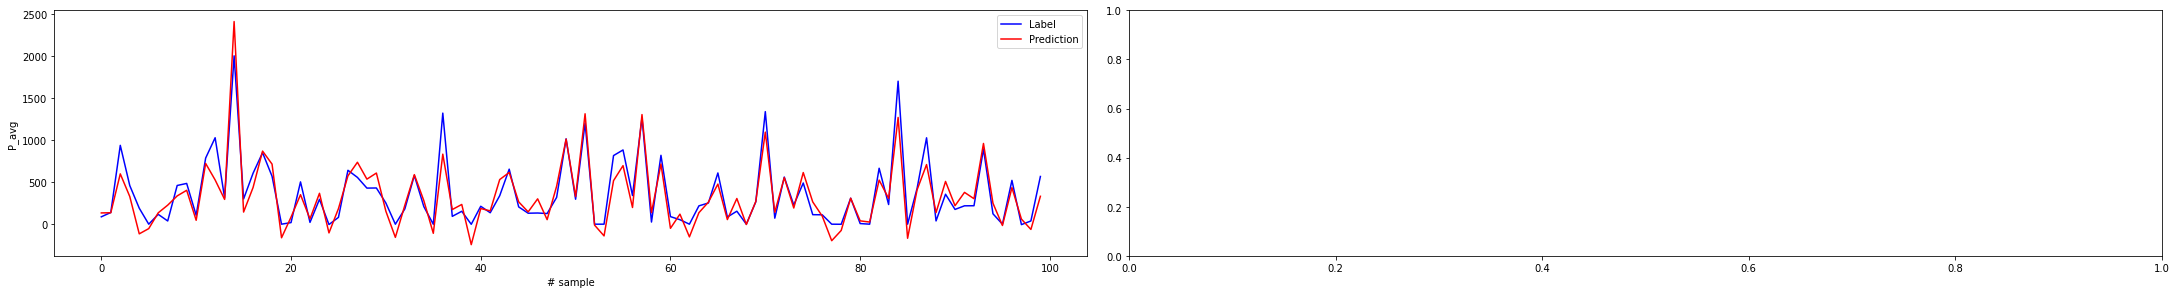

In [33]:
fig, axes = plt.subplots(figsize=(30, 4),nrows=1, ncols=2)
plt.tight_layout()

axes[0].plot(range(num_sample), label, 'b', label='Label')
axes[0].plot(range(num_sample), pred, 'r', label='Prediction')
axes[0].set_xlabel('# sample')
axes[0].set_ylabel('P_avg')
axes[0].legend()

fig.savefig("/content/drive/MyDrive/toqua/pred2.png")

In [34]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_squared_log_error, median_absolute_error, max_error

r2 = r2_score(label, pred)
mae = mean_absolute_error(label, pred)
mse = mean_squared_error(label, pred)
medae = median_absolute_error(label, pred)
me = max_error(label, pred)

print("R2: ", r2)
print("MAE: ", mae)
print("MSE: ", mse)
print("MEDAE: ", medae)
print("ME: ", me)

R2:  0.8528303528891595
MAE:  114.81529749450115
MSE:  23651.47080365197
MEDAE:  91.89577749861644
ME:  502.739799140983
